# updated version of RD900 analysis to detect region differences using raw reads

links

* https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1009061
* https://dmnfarrell.github.io/bioinformatics/rd900-mtbc

In [1]:
import os, io, glob, subprocess
from importlib import reload
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from snpgenie import tools, aligners, app, trees, plotting

In [2]:
read_data = pd.read_csv('../genomes_data.csv')
path = '/storage/elena_data'
read_data[-5:]

,ACCESSION,PAIRED,LINEAGE,ORIGIN,BIOPROJECT,BIOSAMPLE,Reads lenght (bp),LINK1,LINK2,REFERENCE
66,ERR4143897,yes,M. pinnipedii,Portugal,PRJEB29446,SAMEA6830808,145.0,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR414/007/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR414/007/...,NATIONAL INSTITUTE OF HEALTH DR. RICARDO JORGE
67,ERR970409,yes,M. suricattae,NaN,PRJEB9954,SAMEA3491431,100.0,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR970/ERR9...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR970/ERR9...,SAMRC Centre for Tuberculosis Research
68,ERR970412,yes,M. suricattae,NaN,PRJEB9954,SAMEA3491431,163.0,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR970/ERR9...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR970/ERR9...,SAMRC Centre for Tuberculosis Research
69,SRR3745458,yes,Dassie baccillus,South Africa,PRJNA327952,SAMN05362621,233.0,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR374/008/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR374/008/...,USDA Animal Plant Health Inspection Service-Na...
70,ERR713575,yes,Chimpanzee bacillus,Cote d'Ivoire: Tai National Park,PRJNA264305,SAMEA3182759,NaN,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR713/ERR7...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR713/ERR7...,Swiss Tropical and Public Health Institute


In [3]:
#read annotation
rec = list(GFF.parse('RD900MAF.gff'))[0]
#remove gene features for plotting
rec.features

[SeqFeature(FeatureLocation(ExactPosition(6156), ExactPosition(6981), strand=-1), type='gene'),
 SeqFeature(FeatureLocation(ExactPosition(782), ExactPosition(2663), strand=-1), type='gene', id='gene:BQ2027_MB1297C'),
 SeqFeature(FeatureLocation(ExactPosition(1611), ExactPosition(1772), strand=-1), type='domain', id='gene:pknH1_proline'),
 SeqFeature(FeatureLocation(ExactPosition(2906), ExactPosition(5303), strand=-1), type='gene', id='gene:BQ2027_MB1297CA'),
 SeqFeature(FeatureLocation(ExactPosition(5313), ExactPosition(6981), strand=-1), type='gene', id='gene:BQ2027_MB1297CB'),
 SeqFeature(FeatureLocation(ExactPosition(6080), ExactPosition(6153), strand=-1), type='domain', id='gene:pknH2_proline'),
 SeqFeature(FeatureLocation(ExactPosition(6394), ExactPosition(6396), strand=-1), type='gene', id='gene:'),
 SeqFeature(FeatureLocation(ExactPosition(7321), ExactPosition(8514), strand=-1), type='gene', id='gene:_2'),
 SeqFeature(FeatureLocation(ExactPosition(1725), ExactPosition(2663), str

In [ ]:
args = {'threads':20, 'outdir': 'snpgenie_results', 'labelsep':'-',  
        'input':['/storage/elena_data/'],        
        'reference': 'RD900MAF.fa', #'gb_file':'RD900MAF.gb',
        'overwrite':False,
        'filters' : 'QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35'
        }
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [5]:
samples = pd.read_csv('snpgenie_results/summary.csv')
samples = samples.merge(read_data,left_on='sample',right_on='ACCESSION')
samples = samples.sort_values('LINEAGE')

## plot the coverage over the region for each sample

In [6]:
def get_coverage(bam_file, chr, start, end):
    cmd = 'samtools mpileup {b} --min-MQ 10 -f RD900MAF.fa -r {c}:{s}-{e}'.format(c=chr,s=start,e=end,b=bam_file)
    #print(cmd)
    temp = subprocess.check_output(cmd, shell=True)    
    df=pd.read_csv(io.BytesIO(temp), sep='\t', names=['chr','pos','base','coverage','q','c'])
    return df
    
for n,r in list(samples.iterrows())[40:41]:     
     get_coverage(r.bam_file,'RD900MAF',1,len(rec.seq))  

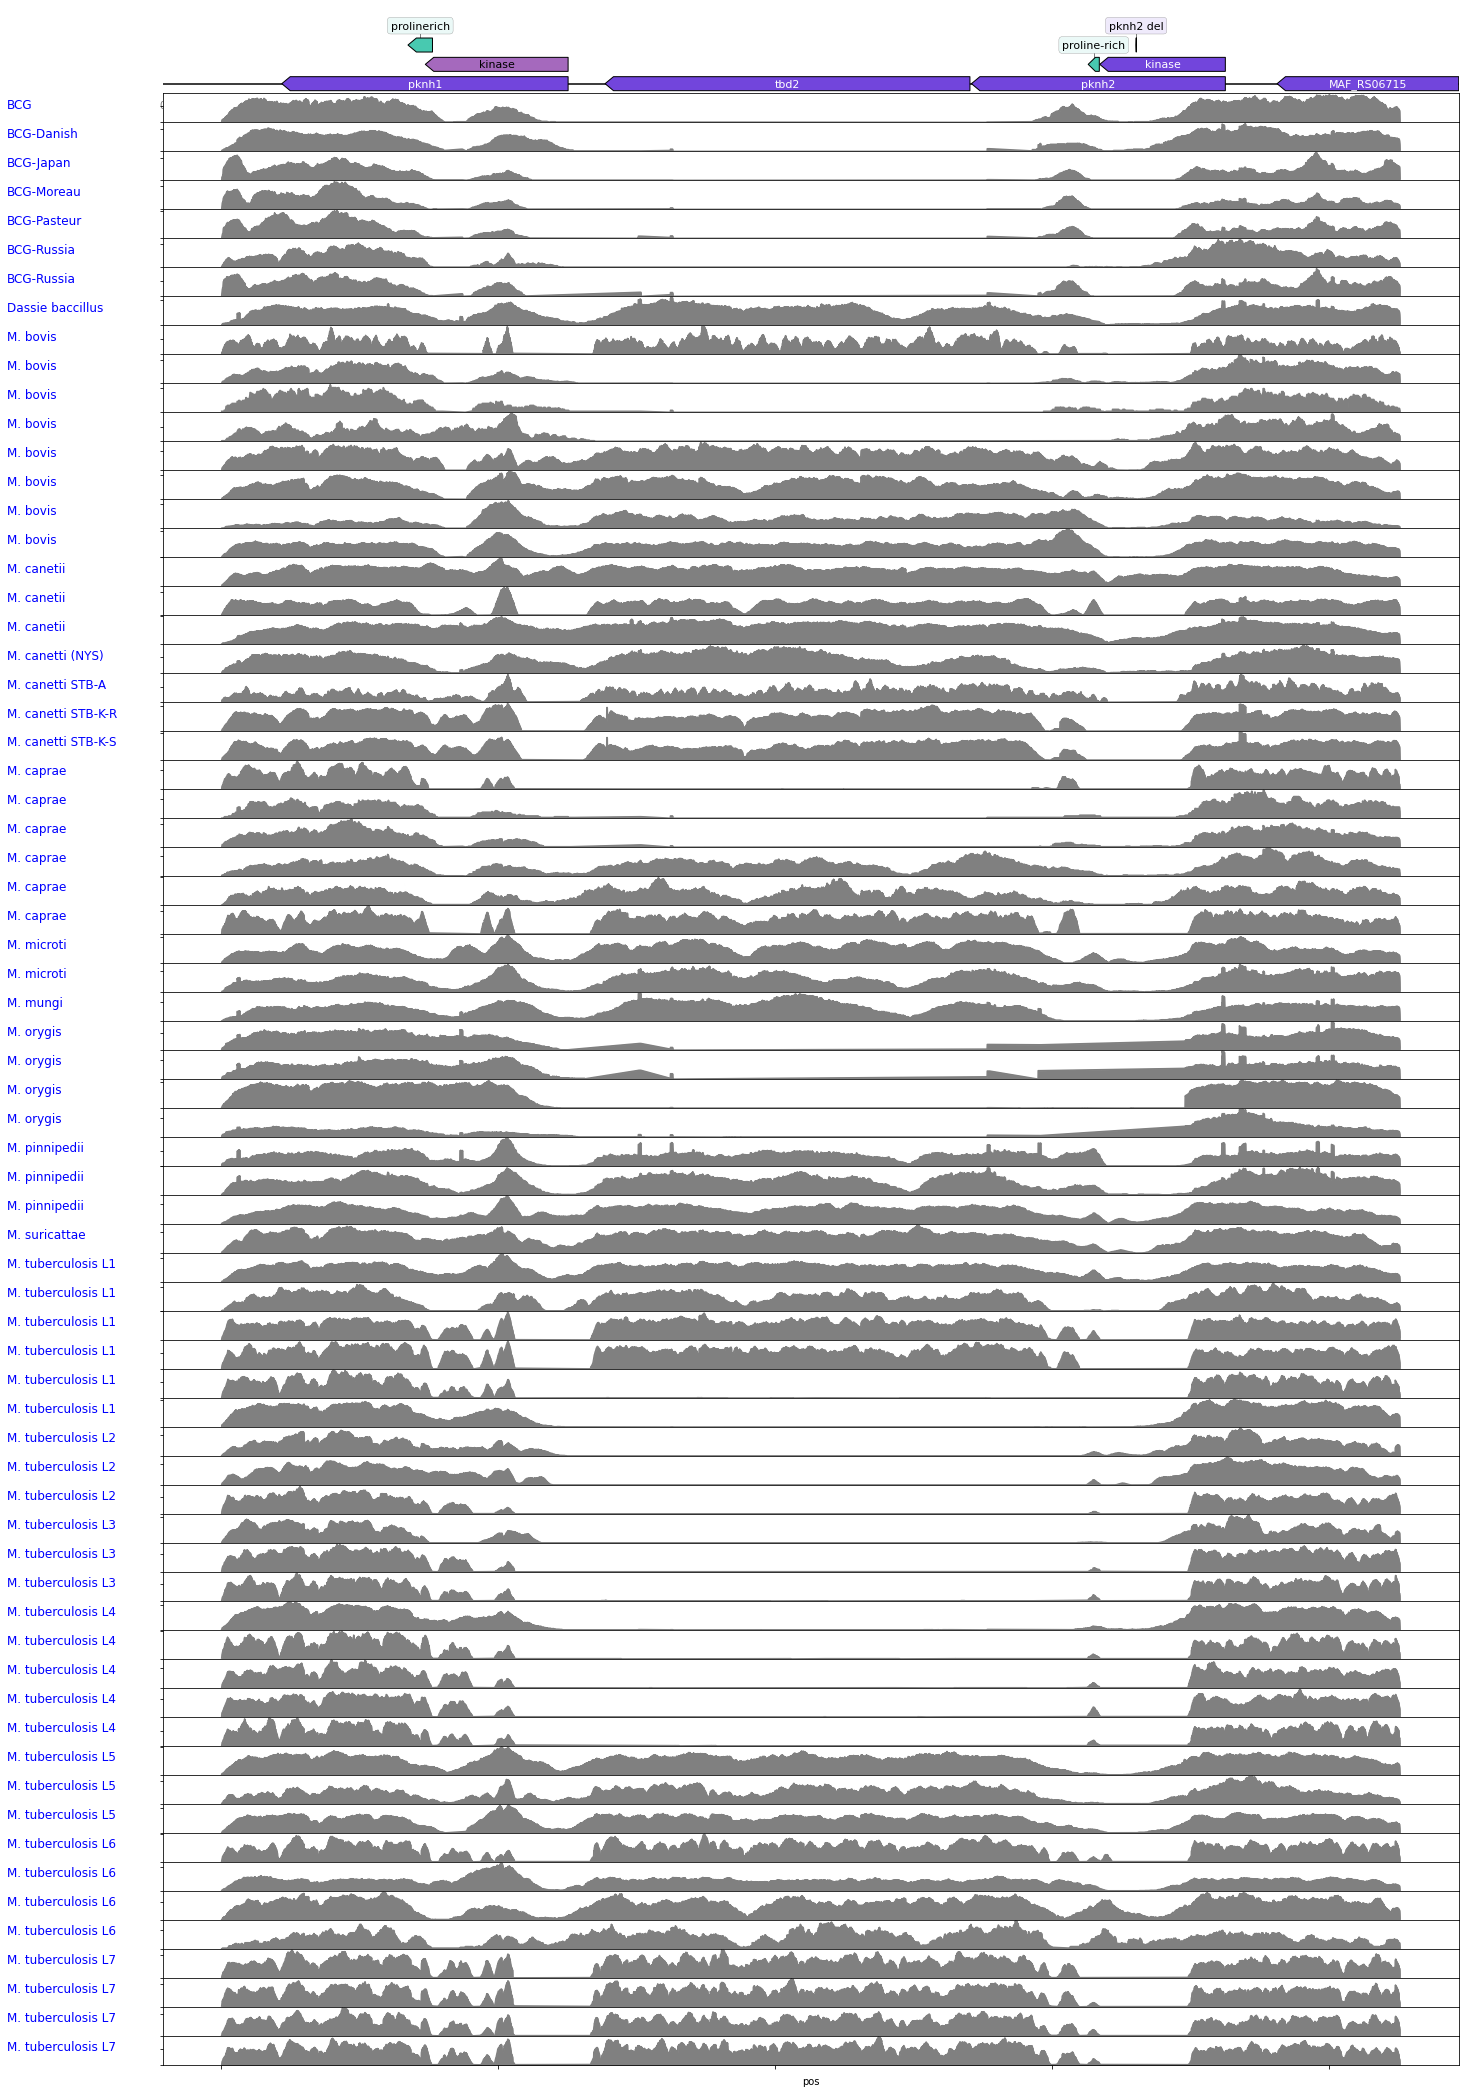

In [8]:
from dna_features_viewer import GraphicFeature, GraphicRecord
from dna_features_viewer import BiopythonTranslator

graphic_record = BiopythonTranslator().translate_record(rec)
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(30,40))
gs = GridSpec(75, 1, figure=fig)
ax1=fig.add_subplot(gs[:3,0])
graphic_record.plot(ax=ax1)
i=3
for n,r in list(samples.iterrows()):#[40:60]:
    ax=fig.add_subplot(gs[i,0])
    df = get_coverage(r.bam_file,'RD900MAF',1,len(rec.seq))
    #bins=range(0,max(df.coverage),int(max(df.coverage)/10))
    #df['binned']=np.searchsorted(bins, df.coverage.values)
    df.plot(x='pos',y='coverage',ax=ax,kind='area',color='gray',legend=False)
    label=r.LINEAGE
    ax.text(-.12,.5,label,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    i+=1
plt.subplots_adjust(left=.3,right=.9,wspace=0, hspace=0)
fig.savefig('rd900_coverage.jpg',dpi=100)

## this code tries to automatically detect presence of regions from the coverage

In [14]:
coords = [(f.id,int(f.location.start),int(f.location.end)) for f in rec.features]
coords

[('', 6156, 6981),
 ('gene:BQ2027_MB1297C', 782, 2663),
 ('gene:pknH1_proline', 1611, 1772),
 ('gene:BQ2027_MB1297CA', 2906, 5303),
 ('gene:BQ2027_MB1297CB', 5313, 6981),
 ('gene:pknH2_proline', 6080, 6153),
 ('gene:', 6394, 6396),
 ('gene:_2', 7321, 8514),
 ('gene:pknH1_kinase', 1725, 2663)]

In [15]:
def detect_coverage(file, ref, coords):
    """Find presence/absence within regions"""

    df = get_coverage(file,'RD900MAF',1,len(rec.seq)).set_index('pos')
    res=[]
    for c in coords:
        start,end=c[1],c[2]
        x = df.loc[start:end]        
        x = (c[0],x.coverage.sum()/(end-start))
        res.append(x)        
    return pd.DataFrame(res,columns=['region','coverage'])

coords = [('pknH1', 782, 2663),
 ('pknH1_proline', 1611, 1772),
 ('tbd2', 2906, 5303),
 ('pknH2', 5313, 6981),
 ('pknH2_proline', 6080, 6153), 
 ('pknH1_kinase', 1725, 2663)]

#detect_coverage('snpgenie_results/mapped/ERR015616.bam','RD900MAF.fa',coords)

In [11]:
M=[] 
for i,r in list(samples.iterrows()):
    res = detect_coverage(r.bam_file,'RD900MAF.fa',coords)
    res['lineage'] = r.LINEAGE
    res['sample'] = r.ACCESSION
    M.append(res)
M=pd.concat(M)

In [12]:
P = pd.pivot_table(M,index=['sample','lineage'],columns=['region'],values='coverage')
P[P<1]=0
P[P>1]=1
print (P[:10])

region                         pknH1  pknH1_kinase  pknH1_proline  pknH2  pknH2_proline  tbd2
sample     lineage                                                                           
ERR015598  M. canetti STB-A      1.0           1.0            1.0    1.0            1.0   1.0
ERR015616  M. tuberculosis L2    1.0           1.0            1.0    1.0            0.0   0.0
ERR017778  BCG-Russia            1.0           1.0            0.0    1.0            1.0   0.0
ERR017801  M. tuberculosis L5    1.0           1.0            1.0    1.0            1.0   1.0
ERR027294  M. microti            1.0           1.0            1.0    1.0            0.0   1.0
ERR1109376 M. canetti STB-K-S    1.0           1.0            1.0    1.0            1.0   1.0
ERR1109377 M. canetti STB-K-R    1.0           1.0            1.0    1.0            1.0   1.0
ERR1200603 M. tuberculosis L7    1.0           1.0            1.0    1.0            1.0   1.0
ERR1200614 M. tuberculosis L4    1.0           1.0          

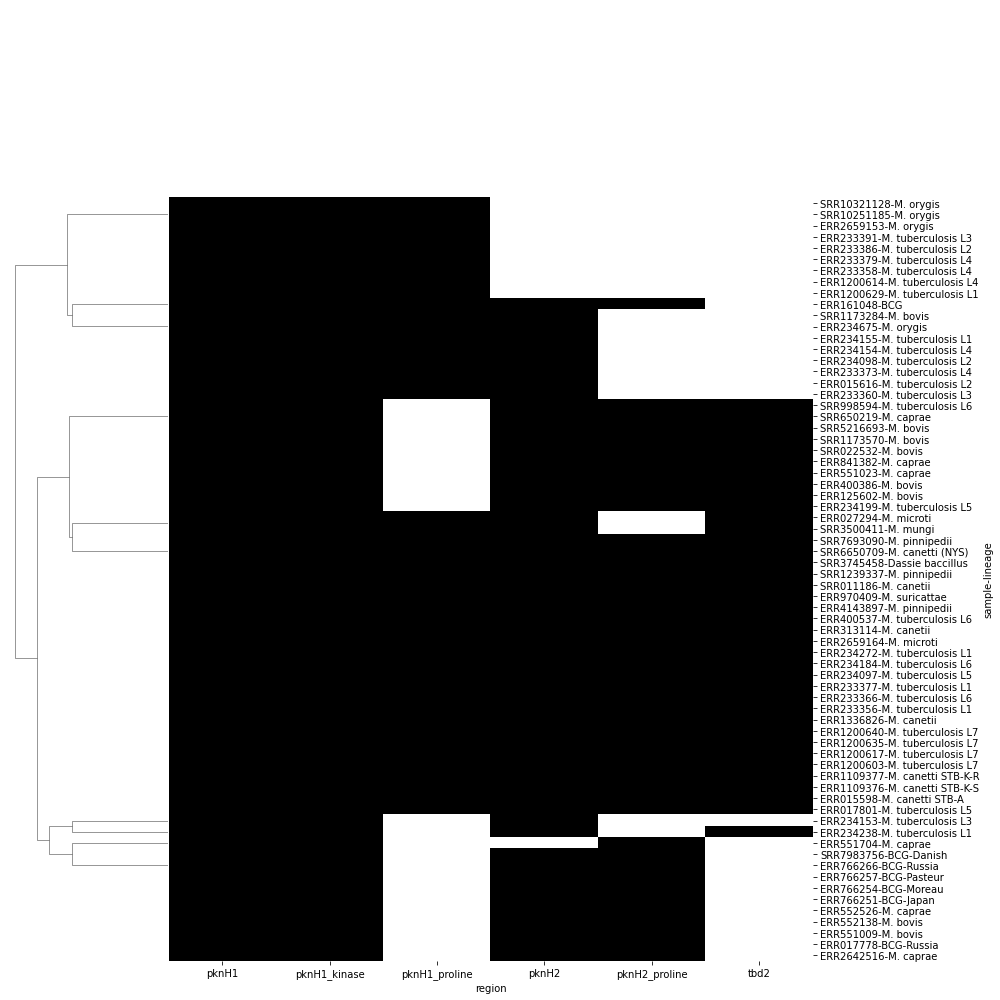

In [13]:
cm=sns.clustermap(P,col_cluster=False,cmap='gray_r',figsize=(14,14),
                  xticklabels=True,yticklabels=True)
cm.cax.set_visible(False)
plt.savefig('rd900_presence_absence.jpg')